In [1]:
import json
import pprint

import healsparse as hsp
import numpy as np
import matplotlib.pyplot as plt
import skyproj
import hpgeom

## Read Hyperleda Catalog

In [3]:
import glob
import tqdm

fnames = sorted(glob.glob("hleda*.csv"))

In [4]:
def _read_fname(fname):
    rows = []
    first_line = True
    last_len = None
    cnames = None
    with open(fname, "r") as fp:
        for line in fp:
            line = line.strip()
            if len(line) == 0 or line[0] == "#":
                continue
            if first_line:
                cnames = line.split(",")
                cnames = [c.strip() for c in cnames]
                # print("columns:", cnames)
                first_line = False
            else:
                vals = line.split(",")
                vals = [val.strip() for val in vals]
                for i, cname in enumerate(cnames):
                    if cname == "pgc":
                        vals[i] = int(vals[i])
                    elif cname in ['al2000', 'de2000', 'logd25', 'logr25', 'pa']:
                        if vals[i]:
                            vals[i] = float(vals[i])
                        else:
                            vals[i] = np.nan
                rows.append(tuple(vals))
                
                if last_len is not None and len(rows[-1]) != last_len:
                    assert False, (last_len, rows[-1])
                last_len = len(rows[-1])
    return rows, cnames

all_rows = []
cnames = None
for fname in tqdm.tqdm(fnames, ncols=80):
    _rows, _cnames = _read_fname(fname)
    all_rows += _rows
    
    if cnames is not None:
        if _cnames is not None:
            assert cnames == _cnames
    elif _cnames is not None:
        cnames = _cnames

dtype = []
for cname in cnames:
    if cname == "pgc":
        dtype.append((cname, "i8"))
    elif cname in ['al2000', 'de2000', 'logd25', 'logr25', 'pa']:
        dtype.append((cname, "f8"))
    else:
        dtype.append((cname, "U20"))

hleda = np.array(all_rows, dtype=dtype)

msk = (
    np.isfinite(hleda["al2000"])
    & np.isfinite(hleda["de2000"])
    & np.isfinite(hleda["logd25"])
)
hleda = hleda[msk]

100%|███████████████████████████████████████████| 91/91 [00:04<00:00, 20.11it/s]


In [5]:
hsm = hsp.HealSparseMap.read("y6-combined-hleda-gaiafull-des-stars-hsmap131k-mdet-v2.hsp")

In [6]:
hleda = np.sort(hleda, order="logd25")[::-1]

NGC0055
NGC0253
NGC0247
NGC0300
IC1613
NGC1316
NGC1365
NGC1532
NGC1291
45


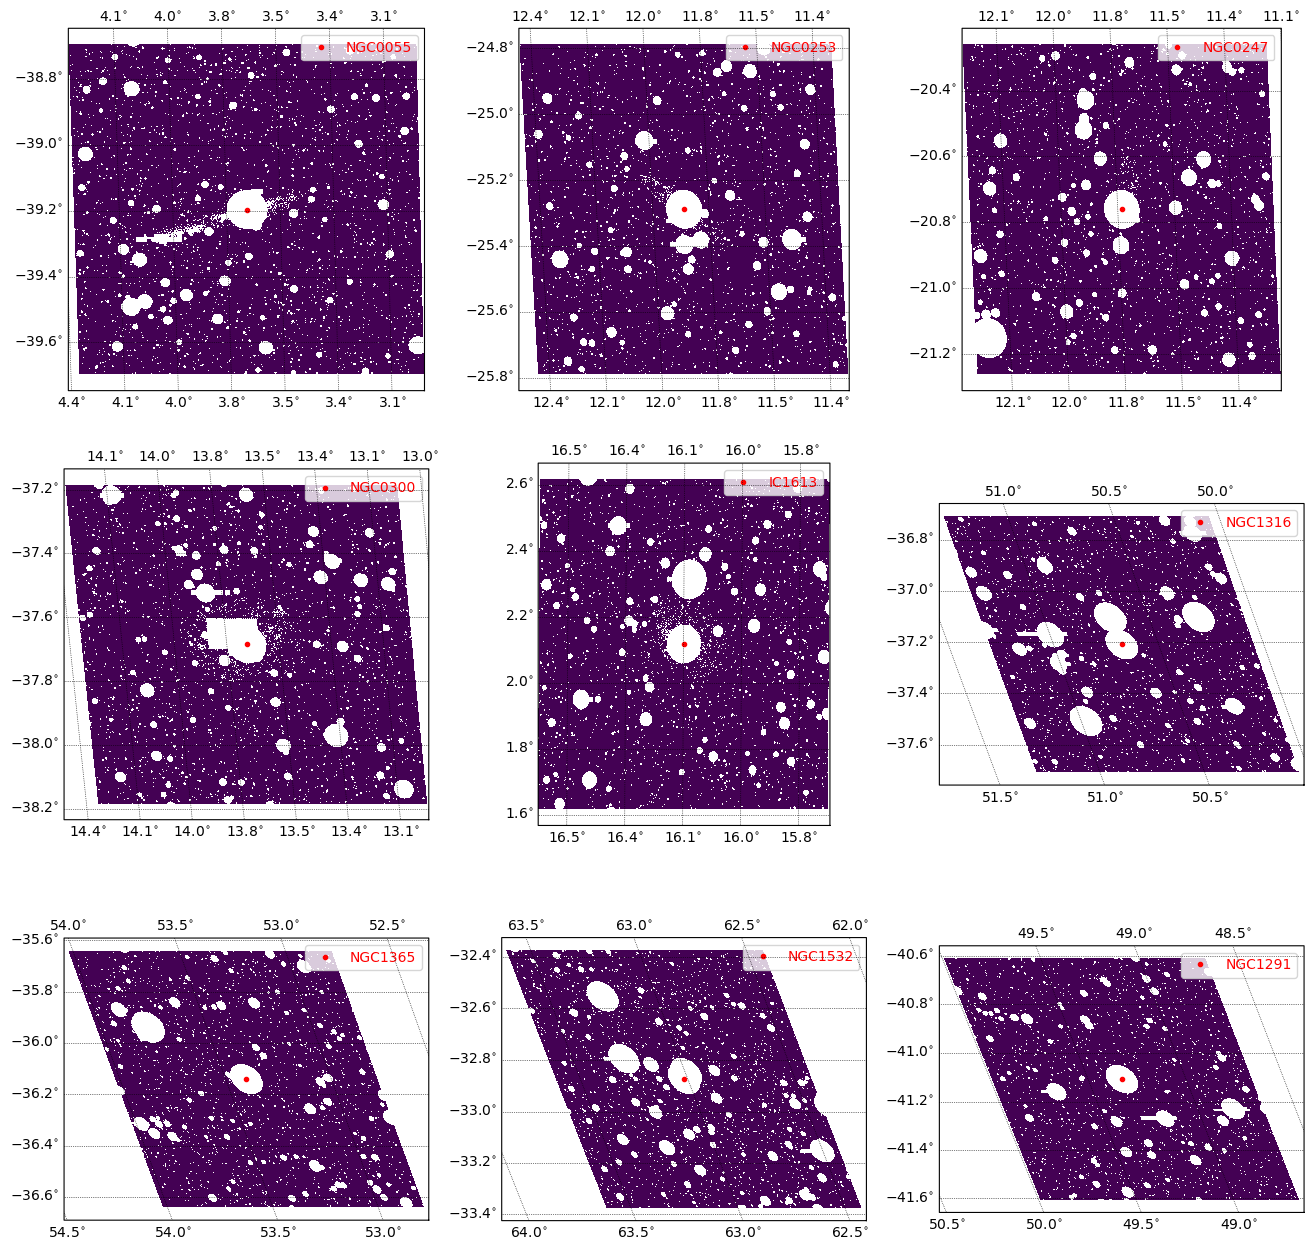

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 16))

axs = axs.ravel()

loc = 0
for i in range(1000):
    ra = hleda["al2000"][i] / 24 * 360
    dec = hleda["de2000"][i]
    dlat = 1 / 2
    dlon = dlat / np.cos(dec / 180 * np.pi)

    rav = np.linspace(-1, 1, 100) * dlon + ra
    decv = np.linspace(-1, 1, 100) * dlat + dec
    vals = hsm.get_values_pos(rav, decv)
    if np.mean(vals) < 0.1:
        # print(f"skipped {hleda['objname'][i]}")
        continue

    ax = axs[loc]
    sp = skyproj.McBrydeSkyproj(ax=ax)
    _ = sp.draw_hspmap(hsm, lon_range=[ra - dlon, ra + dlon], lat_range=[dec - dlat, dec + dlat], cmap="viridis_r")
    # sp.draw_inset_colorbar()
    sp.ax.plot(ra, dec, "r.", label=hleda["objname"][i])
    sp.ax.legend(loc="upper right", labelcolor="red")
    sp.ax.set_xlabel("")
    sp.ax.set_ylabel("")

    loc += 1

    print(hleda['objname'][i])

    if loc == len(axs):
        print(i)
        break
    
plt.show()
    # var = input()
    # if var != "":
    #     break
    # plt.close("all")

## Make New Masks

In [7]:
objects = ["NGC0055", "NGC0253", "NGC0300", "IC1613"]
factors = [0.75, 0.65, 0.75, 0.5]

msk_config = {}
for i, obj in enumerate(objects):
    ind, = np.where(hleda["objname"] == obj)
    assert len(ind) == 1
    ind = ind[0]

    factor = factors[i]

    ra = hleda["al2000"][ind] / 24 * 360.0
    dec = hleda["de2000"][ind]
    
    semi_major = 10**hleda["logd25"][ind] * 0.1 / 60 * factor
    aratio = 10**hleda["logr25"][ind]
    if not np.isfinite(aratio):
        aratio = 1.0
    semi_minor = semi_major / aratio
    pa = hleda["pa"][ind]
    if obj == "IC1613":
        pa = 50
    
    if not np.isfinite(pa):
        pa = 0.0

    _entry = {
        "objname": obj,
        "ra": ra,
        "dec": dec,
        "semi_major": semi_major,
        "semi_minor": semi_minor,
        "pa": pa,
    }
    msk_config[obj] = _entry

pprint.pprint(msk_config)


with open("hleda_extra_mask_config_v1.json", "w") as fp:
    json.dump(msk_config, fp)

{'IC1613': {'dec': 2.1177314,
            'objname': 'IC1613',
            'pa': 50,
            'ra': 16.199166,
            'semi_major': 0.15269286853093428,
            'semi_minor': 0.1428297756257021},
 'NGC0055': {'dec': -39.1965824,
             'objname': 'NGC0055',
             'pa': 102.62,
             'ra': 3.7233674999999997,
             'semi_major': 0.37317282736474505,
             'semi_minor': 0.0380986873703498},
 'NGC0253': {'dec': -25.2884419,
             'objname': 'NGC0253',
             'pa': 52.48,
             'ra': 11.887966500000001,
             'semi_major': 0.2902432351887284,
             'semi_minor': 0.049632037727407784},
 'NGC0300': {'dec': -37.6844766,
             'objname': 'NGC0300',
             'pa': 113.23,
             'ra': 13.723024500000001,
             'semi_major': 0.24261073469909716,
             'semi_minor': 0.16327136101648013}}


NGC0055
NGC0253
NGC0300
IC1613


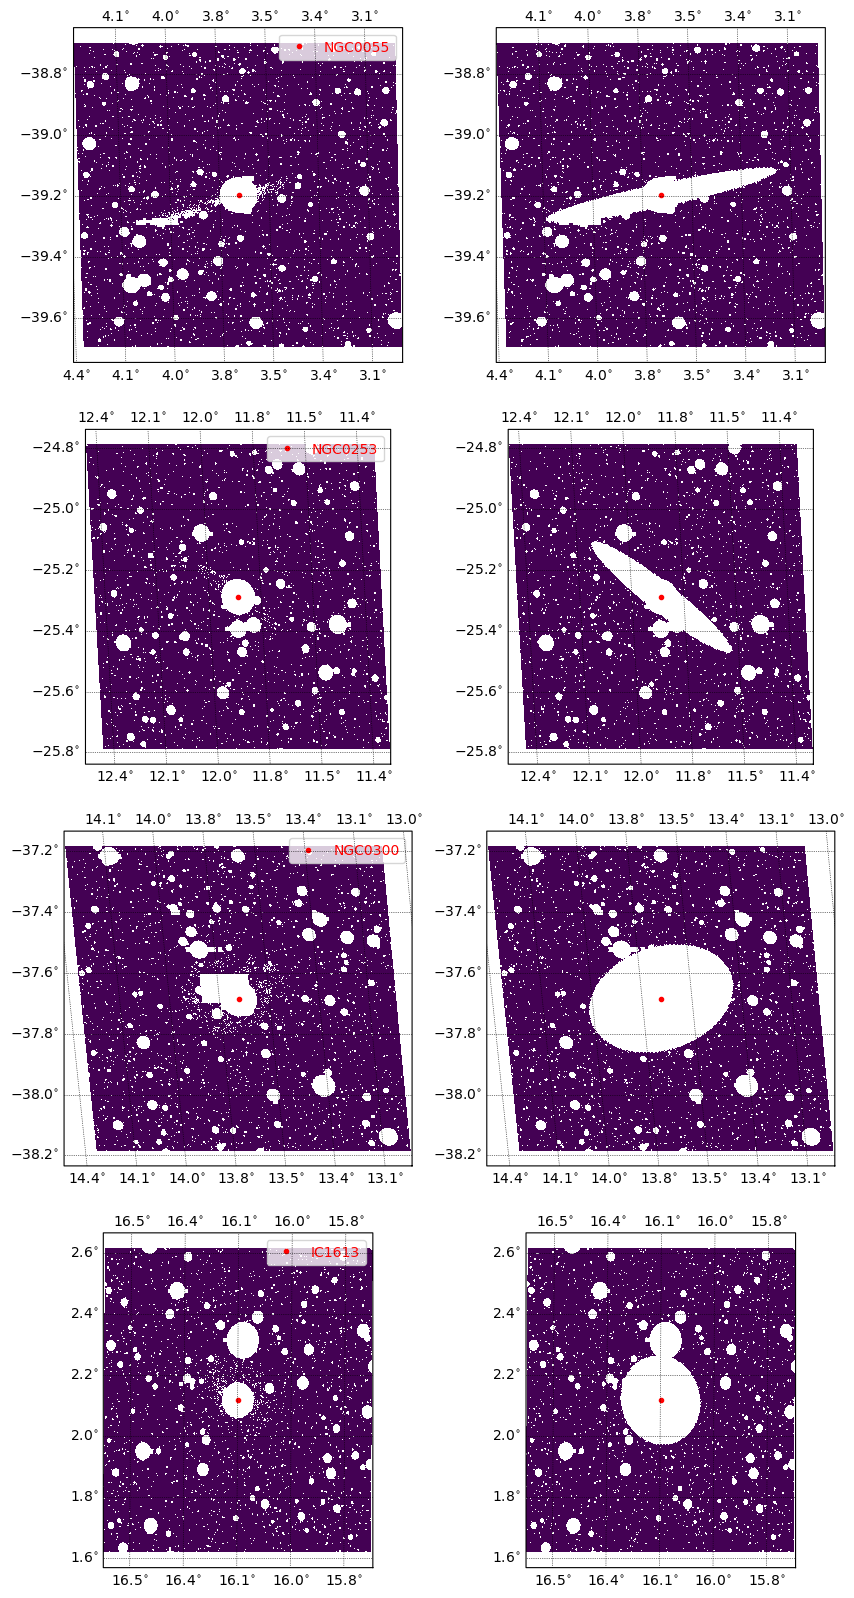

In [11]:
nhsm = hsp.HealSparseMap.read("y6-combined-hleda-gaiafull-des-stars-hsmap131k-mdet-v2.hsp")

final_map = hsp.HealSparseMap.make_empty(
    32,
    2**14,
    bool,
    sentinel=False,
    bit_packed=True,
)   

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i, obj in enumerate(objects):
    print(obj)
    data = msk_config[obj]
    ra = data["ra"]
    dec = data["dec"]
    semi_major = data["semi_major"]
    semi_minor = data["semi_minor"] 
    pa = data["pa"]

    dlat = 1 / 2
    dlon = dlat / np.cos(dec / 180 * np.pi)
    
    nel = hsp.geom.Ellipse(
        ra=ra, 
        dec=dec, 
        semi_major=semi_major, 
        semi_minor=semi_minor, 
        alpha=pa, 
        value=1,
    )
    
    hnel16 = nel.get_map(nside_coverage=32, nside_sparse=2**14, dtype=int)
    
    final_map.update_values_pix(hnel16.valid_pixels, True)
    
    hnel16_131 = hnel16.upgrade(2**17)
    
    nhsm.update_values_pix(hnel16_131.valid_pixels, 0)

    ax = axs[i, 0]
    sp = skyproj.McBrydeSkyproj(ax=ax)
    # Note that the default is to zoom in to the range defined by the map
    _ = sp.draw_hspmap(hsm, lon_range=[ra - dlon, ra + dlon], lat_range=[dec - dlat, dec + dlat], cmap="viridis_r")
    # sp.draw_inset_colorbar()
    sp.ax.plot(ra, dec, "r.", label=obj)
    sp.ax.legend(loc="upper right", labelcolor="red")
    sp.ax.set_xlabel("")
    sp.ax.set_ylabel("")
    
    ax = axs[i, 1]
    sp = skyproj.McBrydeSkyproj(ax=ax)
    # Note that the default is to zoom in to the range defined by the map
    _ = sp.draw_hspmap(nhsm, lon_range=[ra - dlon, ra + dlon], lat_range=[dec - dlat, dec + dlat], cmap="viridis_r")
    # sp.draw_inset_colorbar()
    sp.ax.plot(ra, dec, "r.")
    sp.ax.set_xlabel("")
    sp.ax.set_ylabel("")

plt.savefig("hleda_extra_mask_v1.png", dpi=300)
plt.show()

final_map.write("hleda_extra_mask_v1.hsp", clobber=True)

In [12]:
print("total masked area in new masks:", final_map.n_valid * hpgeom.nside_to_pixel_area(final_map.nside_sparse))

total masked area in new masks: 0.28287228447607804


In [13]:
print("total masked area after overlaps:", (hsm.n_valid - nhsm.n_valid) * hpgeom.nside_to_pixel_area(hsm.nside_sparse))

total masked area after overlaps: 0.2039139636494084


## Hacking and Testing Code

In [ ]:
ra = 0.7925311 / 24 * 360
dec = -25.2884419
semi_minor = 1.9 / 60.0
r25 = 10**0.767
pa = 52.48

nel = hsp.geom.Ellipse(ra=ra, dec=dec, semi_major=r25 * semi_minor, semi_minor=semi_minor, alpha=pa, value=1)

hnel16 = nel.get_map(nside_coverage=32, nside_sparse=2**14, dtype=int)
hnel16_131 = hnel16.upgrade(2**17)

nhsm = hsp.HealSparseMap.read("~/Desktop/y6-combined-hleda-gaiafull-des-stars-hsmap131k-mdet-v2.hsp")
nhsm.update_values_pix(hnel16_131.valid_pixels, 0)

In [ ]:
fig = plt.figure(1, figsize=(12, 10))
fig.clf()
ax = fig.add_subplot(121)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(hsm, lon_range=[11.5, 12.2], lat_range=[-25.1, -25.5], cmap="viridis_r")
# sp.draw_inset_colorbar()
sp.ax.plot(ra, dec, "ro")


ax = fig.add_subplot(122)
sp = skyproj.McBrydeSkyproj(ax=ax)
# Note that the default is to zoom in to the range defined by the map
_ = sp.draw_hspmap(nhsm, lon_range=[11.5, 12.2], lat_range=[-25.1, -25.5], cmap="viridis_r")
# sp.draw_inset_colorbar()
sp.ax.plot(ra, dec, "ro")

plt.show()